In [300]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
from datetime import date, timedelta
from statsmodels.formula.api import ols

from arable_physics import *

pd.options.mode.chained_assignment = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
# Read in a local file 
filename = r'../dat/B00008_treasury_hourly.csv'
b08 = pd.read_csv(filename)
b08['dt'] = pd.to_datetime(b08['time'], format='%Y-%m-%d %H:%M:%S')
b08.index = b08['dt']

# note b11 becomes b20
filename = r'../dat/B00011_treasury_hourly.csv'
b11 = pd.read_csv(filename)
b11['dt'] = pd.to_datetime(b11['time'], format='%Y-%m-%d %H:%M:%S')
b11.index = b11['dt']
b11[b11 < -50] = np.nan

filename = r'../dat/B00020_treasury_hourly.csv'
b20 = pd.read_csv(filename)
b20['dt'] = pd.to_datetime(b20['time'], format='%Y-%m-%d %H:%M:%S')
b20.index = b20['dt']
b20[b20 < -50] = np.nan

b1120 = pd.concat([b11, b20])

In [95]:
mindt = [min(b08.dt), min(b1120.dt)]
maxdt = [max(b08.dt), max(b1120.dt)]
mask = (b08['dt'] >= pd.to_datetime('20160806', format='%Y%m%d'))
b08 = b08.loc[mask]

mask = (b1120['dt'] >= pd.to_datetime('20160806', format='%Y%m%d'))
b1120 = b1120.loc[mask]


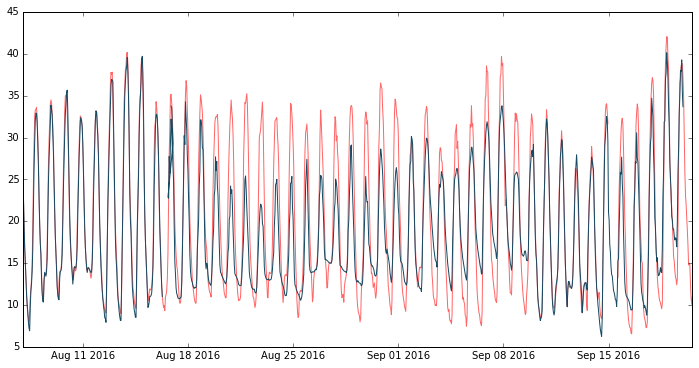

In [96]:
fig, axes = plt.subplots(figsize=(12,6))
line1, = axes.plot(b08.index, b08['Tair'], color='#ff6768', label = 'Tair')
line2, = axes.plot(b1120.index, b1120['Tair'], color='#174a63', label = 'Tair')


# Light Measurements are Screwy

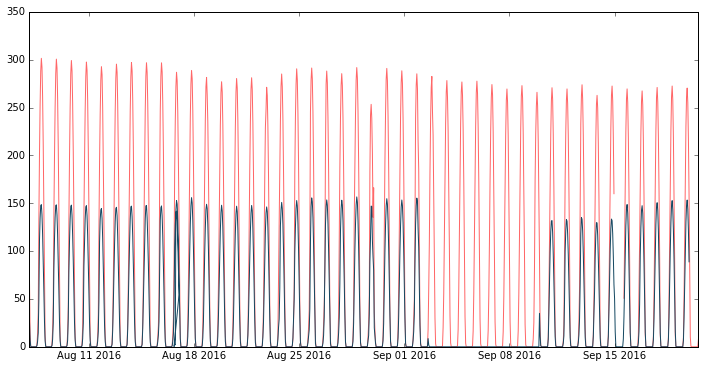

In [217]:
fig, axes = plt.subplots(figsize=(12,6))
line1, = axes.plot(b08.index, b08['B2dw'], color='#ff6768', label = 'Tair')
line2, = axes.plot(b1120.index, b1120['B2dw'], color='#174a63', label = 'Tair')


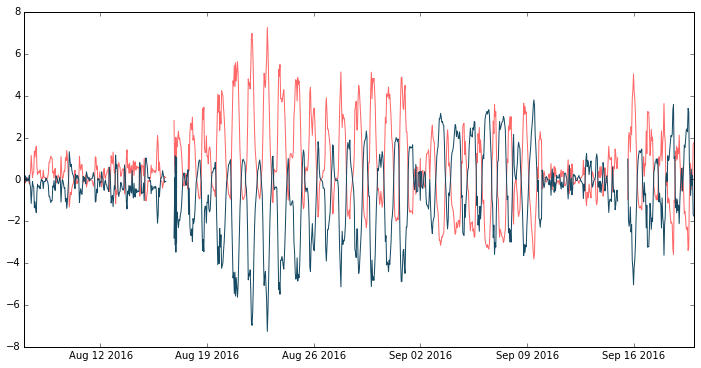

In [123]:
# calculate the average over all time
mean = pd.DataFrame()
#mean['Tair'] = (b08['Tair'] + b1120['Tair'])/2
for key in b1120.keys():
    if (key != 'time') & (key != 'dt'):
        mean[key] = (b08[key] + b1120[key])/2
        del08[key] = b08[key] - mean[key]
        del1120[key] = b1120[key] - mean[key]

fig, axes = plt.subplots(figsize=(12,6))
line1, = axes.plot(del08.index, del08['Tair'], color='#ff6768', label = 'Tair')
line2, = axes.plot(del1120.index, del1120['Tair'], color='#174a63', label = 'Tair')


# Calculate Heat Accumulation

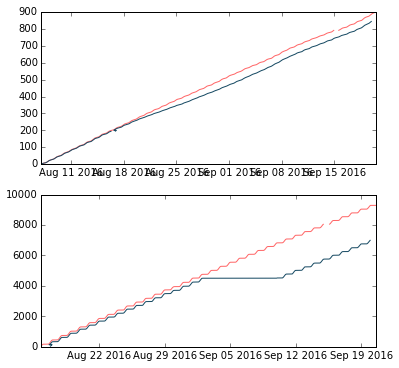

In [254]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,6))
line1, = axes[0].plot(b08.index, np.cumsum(b08['Tair']/24), color='#ff6768', label = 'Tair')
line2, = axes[0].plot(b1120.index, np.cumsum(b1120['Tair']/24), color='#174a63', label = 'Tair')


line1, = axes[1].plot(b08.index, np.cumsum(b08['SWdw']/24), color='#ff6768', label = 'Tair')
line2, = axes[1].plot(b1120.index, np.cumsum(b1120['SWdw']/24), color='#174a63', label = 'Tair')

# Calculate Mean Diurnal Cycle

In [344]:
dt = pd.date_range('8/7/2016 13:00:00', periods=24, freq='H')

mdc08 = pd.DataFrame()
mdc08['dt'] = dt
mdc08.index = mdc08['dt']
mdc08['Tair'] = np.zeros(np.shape(mdc08.dt))
mdc08['SWdw'] = np.zeros(np.shape(mdc08.dt))

mdc1120 = pd.DataFrame()
mdc1120['dt'] = dt
mdc1120.index = mdc1120['dt']
mdc1120['Tair'] = np.zeros(np.shape(mdc1120.dt))

for i in range(24):
    #ih = mdc08.index.hour[i]
    mask = (b08.index.hour == mdc08.index.hour[i])
    temp = b08.loc[mask]
    mdc08['Tair'].iloc[i] = np.mean(temp['Tair'])
    mdc08['SWdw'].iloc[i] = np.mean(temp['SWdw'])
    
    mask = (b1120.index.hour == mdc08.index.hour[i])
    temp = b1120.loc[mask]
    mdc1120['Tair'].iloc[i] = np.mean(temp['Tair'])    

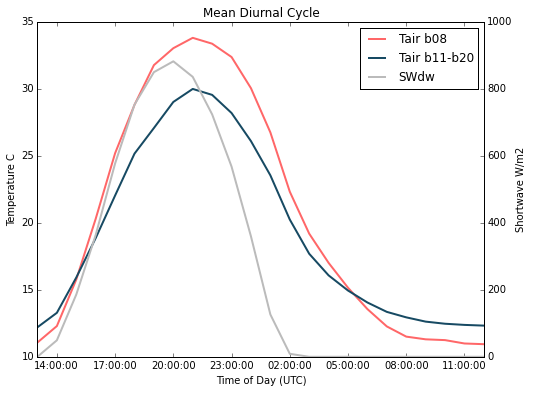

In [353]:
fig, axes = plt.subplots(figsize=(8,6))
line1, = axes.plot(mdc08.index, mdc08['Tair'], color='#ff6768', label = 'Tair b08', linewidth=2)
line2, = axes.plot(mdc1120.index, mdc1120['Tair'], color='#174a63', label = 'Tair b11-b20', linewidth=2)
axes.set_title('Mean Diurnal Cycle')
axes.set_xlabel('Time of Day (UTC)')
axes.set_ylabel('Temperature C')

axes2 = axes.twinx()
line3, = axes2.plot(mdc08.index, mdc08['SWdw'], color='#bbbbbb', label = 'SWdw', linewidth=2)
axes2.set_ylabel('Shortwave W/m2')
axes2.set_ylim([0, 1000])

axes.legend(handles=[line1, line2, line3], loc=1)


# Leaf Wetness

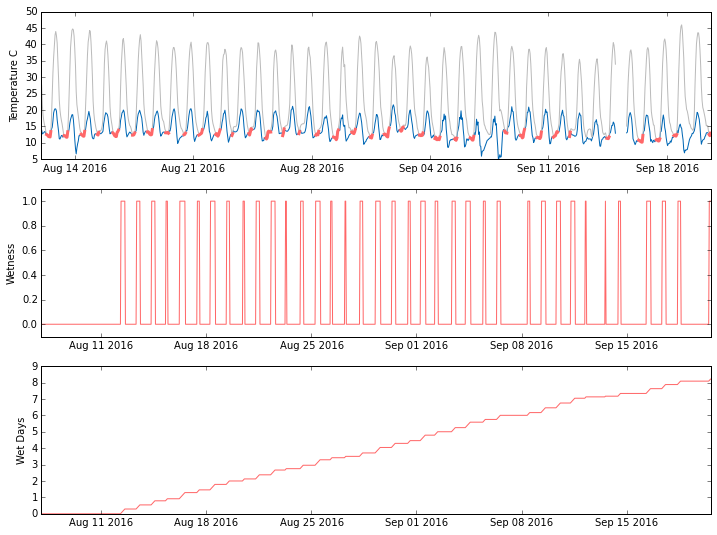

In [341]:
b08['Tdew_leaf'] = Tdew_(b08['Tbelow'], b08['RH']/100)
b08['Tdew_leaf_mk'] = b08['Tdew_leaf']
b08['Wet_leaf'] = b08['Tdew_leaf'] >= b08['Tbelow']*0.95
b08['Tdew_air'] = Tdew_(b08['Tair'], b08['RH']/100)
b08['Tdew_air_mk'] = Tdew_(b08['Tdew_air'], b08['RH']/100)
b08['Wet_air'] = b08['Tdew_air'] >= b08['Tair']*0.95
mask = ~b08['Wet_leaf']
b08['Tdew_leaf_mk'].loc[mask] = np.nan

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,9))
line1, = axes[0].plot(b08.index, b08['Tdew_leaf'], color='#0067B5', label = 'Tdew', linewidth=1)
line2, = axes[0].plot(b08.index, b08['Tbelow'], color='#bbbbbb', label = 'Tleaf')
line3, = axes[0].plot(b08.index, b08['Tdew_leaf_mk'], color='#ff6768', label = 'Tdew', linewidth=3)
axes[0].set_ylabel('Temperature C')

line1, = axes[1].plot(b08.index, b08['Wet_leaf']*1, color='#ff6768', label = 'Tdew')
axes[1].set_ylim([-0.1, 1.1])
axes[1].set_ylabel('Wetness')

line1, = axes[2].plot(b08.index, np.cumsum(b08['Wet_leaf']/24), color='#ff6768', label = 'Tdew')
axes[2].set_ylabel('Wet Days')


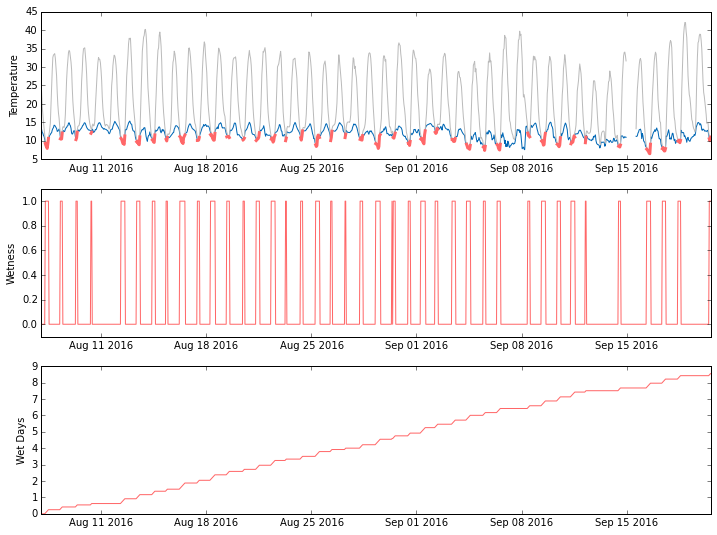

In [340]:
b08['Tdew_air'] = Tdew_(b08['Tair'], b08['RH']/100)
b08['Tdew_air_mk'] = Tdew_(b08['Tdew_air'], b08['RH']/100)
b08['Wet_air'] = b08['Tdew_air'] >= b08['Tair']*0.95
mask = ~b08['Wet_air']
b08['Tdew_air_mk'].loc[mask] = np.nan

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,9))
line1, = axes[0].plot(b08.index, b08['Tdew_air'], color='#0067B5', label = 'Tdew', linewidth=1)
line2, = axes[0].plot(b08.index, b08['Tair'], color='#bbbbbb', label = 'Tleaf')
line3, = axes[0].plot(b08.index, b08['Tdew_air_mk'], color='#ff6768', label = 'Tdew', linewidth=3)
axes[0].set_ylabel('Temperature C')

line1, = axes[1].plot(b08.index, b08['Wet_air']*1, color='#ff6768', label = 'Tdew')
axes[1].set_ylim([-0.1, 1.1])
axes[1].set_ylabel('Wetness')

line1, = axes[2].plot(b08.index, np.cumsum(b08['Wet_air']/24), color='#ff6768', label = 'Tdew')
axes[2].set_ylabel('Wet Days')


# Disease Model
* http://ipm.ucanr.edu/DISEASE/DATABASE/grapepowderymildew.html

* http://ipm.ucanr.edu/DISEASE/DATABASE/potatolateblight.html

* http://ipm.ucanr.edu/DISEASE/DATABASE/grapebotrytis.html

# Crop Water Demand

#Leaf-air temp stress